# Einführung

::: {.callout-note}
## Über dieses Notebook
Dieses Notebook demonstriert den **PRECISION Workflow** - von der explorativen Datenanalyse bis zur automatisierten Publikation in verschiedenen Formaten.
:::

Die **Präzisionsmedizin** revolutioniert die Behandlung von Krankheiten durch personalisierte Therapieansätze [@collins2015]. Anstatt "one-size-fits-all" Behandlungen anzuwenden, nutzen wir **Biomarker** und **genetische Profile**, um die optimale Therapie für jeden Patienten zu identifizieren [@schork2015].

In dieser Analyse untersuchen wir:

1. **Biomarker-Profile** verschiedener Patientengruppen
2. **Prädiktive Modelle** für Therapie-Response
3. **Visualisierungen** für klinische Entscheidungsunterstützung

In [12]:
#| label: setup
#| code-fold: true
#| code-summary: "Bibliotheken & Konfiguration"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# ═══════════════════════════════════════════════════════════════
# PRECISION Design System
# ═══════════════════════════════════════════════════════════════

PRECISION = {
    'primary': '#005a8c',      # Klinisches Blau
    'secondary': '#007cb0',    # Helles Blau
    'accent': '#00a0d2',       # Akzent-Blau
    'success': '#4a9b5e',      # Erfolg/Responder
    'warning': '#e8a027',      # Warnung
    'danger': '#c9302c',       # Fehler/Non-Responder
    'light': '#f8f9fa',        # Hintergrund
    'dark': '#2c3e50'          # Text
}

# Matplotlib Styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'figure.dpi': 150,
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.fontsize': 11,
    'figure.facecolor': 'white'
})

print('✓ PRECISION Analytics Environment initialisiert')
print(f'  → Pandas {pd.__version__}')
print(f'  → NumPy {np.__version__}')

✓ PRECISION Analytics Environment initialisiert
  → Pandas 2.3.3
  → NumPy 2.3.5


---

# Datensatz: OncoPredict Studie

Wir analysieren Daten einer fiktiven klinischen Studie zur **Immuntherapie bei fortgeschrittenen Tumoren**. Der Datensatz enthält Biomarker-Profile und Therapie-Outcomes.

In [13]:
#| label: data-generation
#| code-fold: true
#| code-summary: "Datengenerierung"

np.random.seed(2025)
n = 300

# Patientenstammdaten
data = {
    'patient_id': [f'ONC-{i:04d}' for i in range(1, n + 1)],
    'age': np.random.normal(62, 12, n).astype(int).clip(25, 85),
    'sex': np.random.choice(['Male', 'Female'], n, p=[0.55, 0.45]),
    'stage': np.random.choice(['III', 'IV'], n, p=[0.35, 0.65]),
}

# Biomarker (kontinuierlich)
data['PDL1_expression'] = np.random.exponential(25, n).clip(0, 100).round(1)
data['TMB_score'] = np.random.exponential(8, n).clip(0, 50).round(1)  # Tumor Mutational Burden
data['CD8_infiltration'] = np.random.normal(35, 15, n).clip(5, 80).round(1)
data['IL6_level'] = np.random.exponential(12, n).clip(0, 100).round(1)
data['CRP_level'] = np.random.exponential(15, n).clip(0, 150).round(1)

# Behandlungsgruppen
data['therapy'] = np.random.choice(
    ['Pembrolizumab', 'Nivolumab', 'Combination', 'Chemotherapy'], 
    n, p=[0.3, 0.25, 0.25, 0.2]
)

# Response simulieren (abhängig von Biomarkern)
df = pd.DataFrame(data)

# Response-Wahrscheinlichkeit basierend auf Biomarkern
response_prob = (
    0.3 +
    0.005 * df['PDL1_expression'] +
    0.01 * df['TMB_score'] +
    0.003 * df['CD8_infiltration'] -
    0.002 * df['IL6_level'] -
    0.001 * df['CRP_level'] +
    np.where(df['therapy'].isin(['Pembrolizumab', 'Nivolumab', 'Combination']), 0.1, 0)
).clip(0.1, 0.9)

df['response'] = np.random.binomial(1, response_prob)
df['response_label'] = df['response'].map({1: 'Responder', 0: 'Non-Responder'})

# Progressionsfreies Überleben (Monate)
df['PFS_months'] = np.where(
    df['response'] == 1,
    np.random.exponential(18, n).clip(3, 48),
    np.random.exponential(6, n).clip(1, 18)
).round(1)

print(f'✓ OncoPredict Datensatz generiert: {len(df)} Patienten')

✓ OncoPredict Datensatz generiert: 300 Patienten


In [14]:
#| label: tbl-overview
#| tbl-cap: "Erste 10 Patienten des OncoPredict Datensatzes"

display_cols = ['patient_id', 'age', 'sex', 'stage', 'PDL1_expression']
df[display_cols].head(10)

,patient_id,age,sex,stage,PDL1_expression
0,ONC-0001,60,Female,IV,39.5
1,ONC-0002,70,Female,III,7.7
2,ONC-0003,44,Male,IV,25.9
3,ONC-0004,54,Male,III,16.6
4,ONC-0005,60,Male,III,30.8
5,ONC-0006,85,Male,IV,0.4
6,ONC-0007,78,Male,IV,25.4
7,ONC-0008,59,Male,III,1.5
8,ONC-0009,71,Male,IV,13.4
9,ONC-0010,64,Female,IV,27.8


## Studienübersicht

::: {.callout-tip}
## Key Statistics
Die wichtigsten Kennzahlen der Studie auf einen Blick.
:::

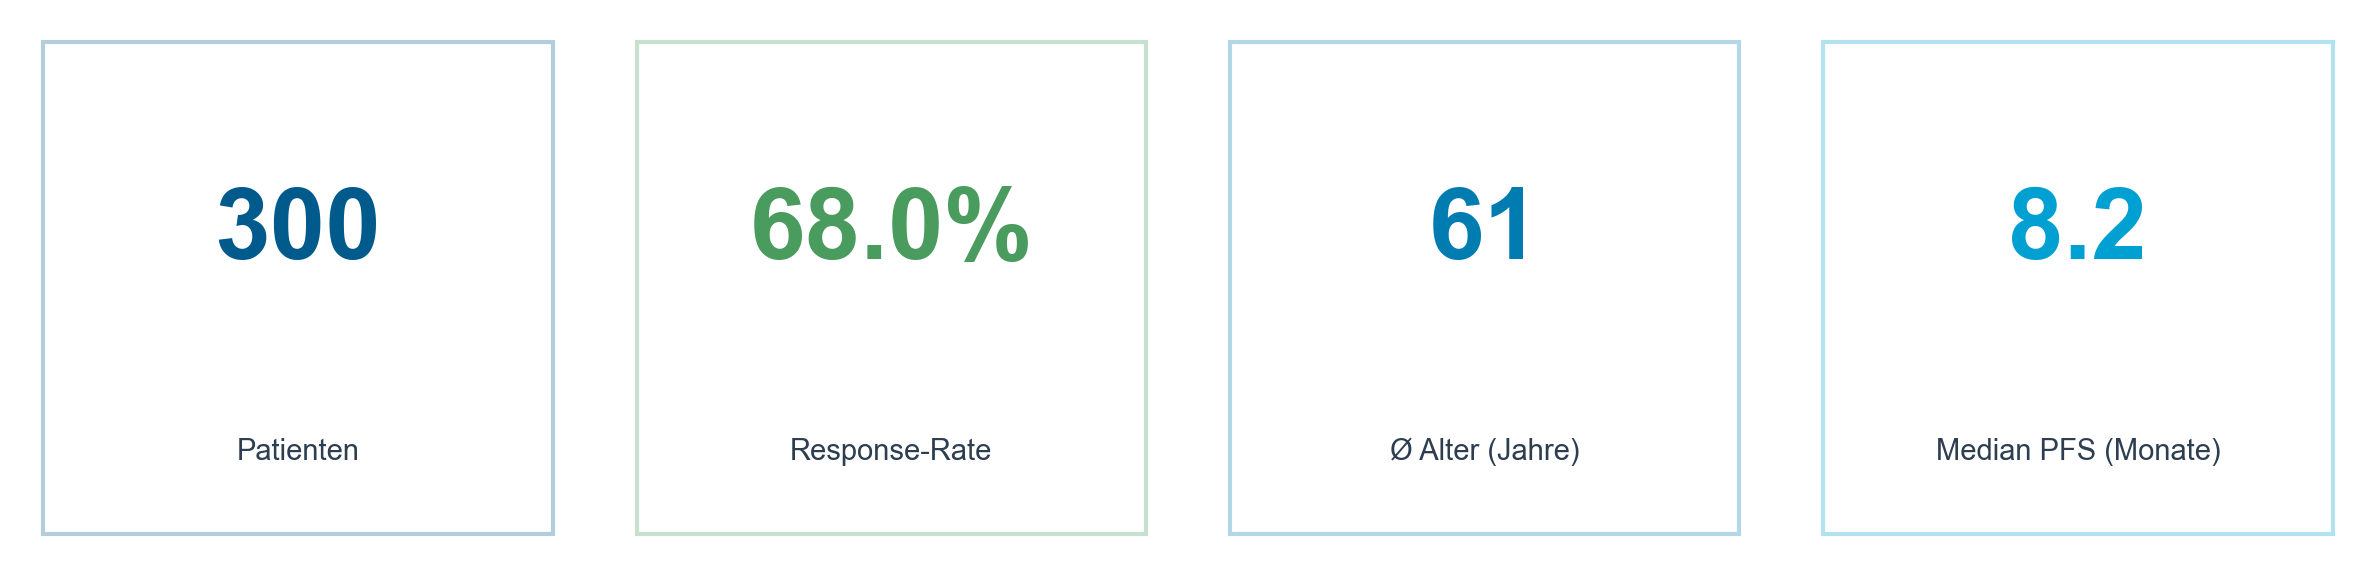

In [15]:
#| label: fig-key-stats
#| fig-cap: "Studienübersicht: Zentrale Kennzahlen der OncoPredict Kohorte"

fig = plt.figure(figsize=(16, 4))

# Key Metrics als große Zahlen
metrics = [
    (f"{len(df)}", "Patienten", PRECISION['primary']),
    (f"{df['response'].mean()*100:.1f}%", "Response-Rate", PRECISION['success']),
    (f"{df['age'].mean():.0f}", "Ø Alter (Jahre)", PRECISION['secondary']),
    (f"{df['PFS_months'].median():.1f}", "Median PFS (Monate)", PRECISION['accent']),
]

for i, (value, label, color) in enumerate(metrics):
    ax = fig.add_subplot(1, 4, i+1)
    ax.text(0.5, 0.6, value, ha='center', va='center', fontsize=48, fontweight='bold', color=color)
    ax.text(0.5, 0.2, label, ha='center', va='center', fontsize=14, color=PRECISION['dark'])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Dezente Box
    rect = plt.Rectangle((0.05, 0.05), 0.9, 0.9, fill=False, edgecolor=color, linewidth=2, alpha=0.3)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

---

# Biomarker-Analyse

Wir untersuchen die Verteilung und den prädiktiven Wert verschiedener Marker [@tufte2001].

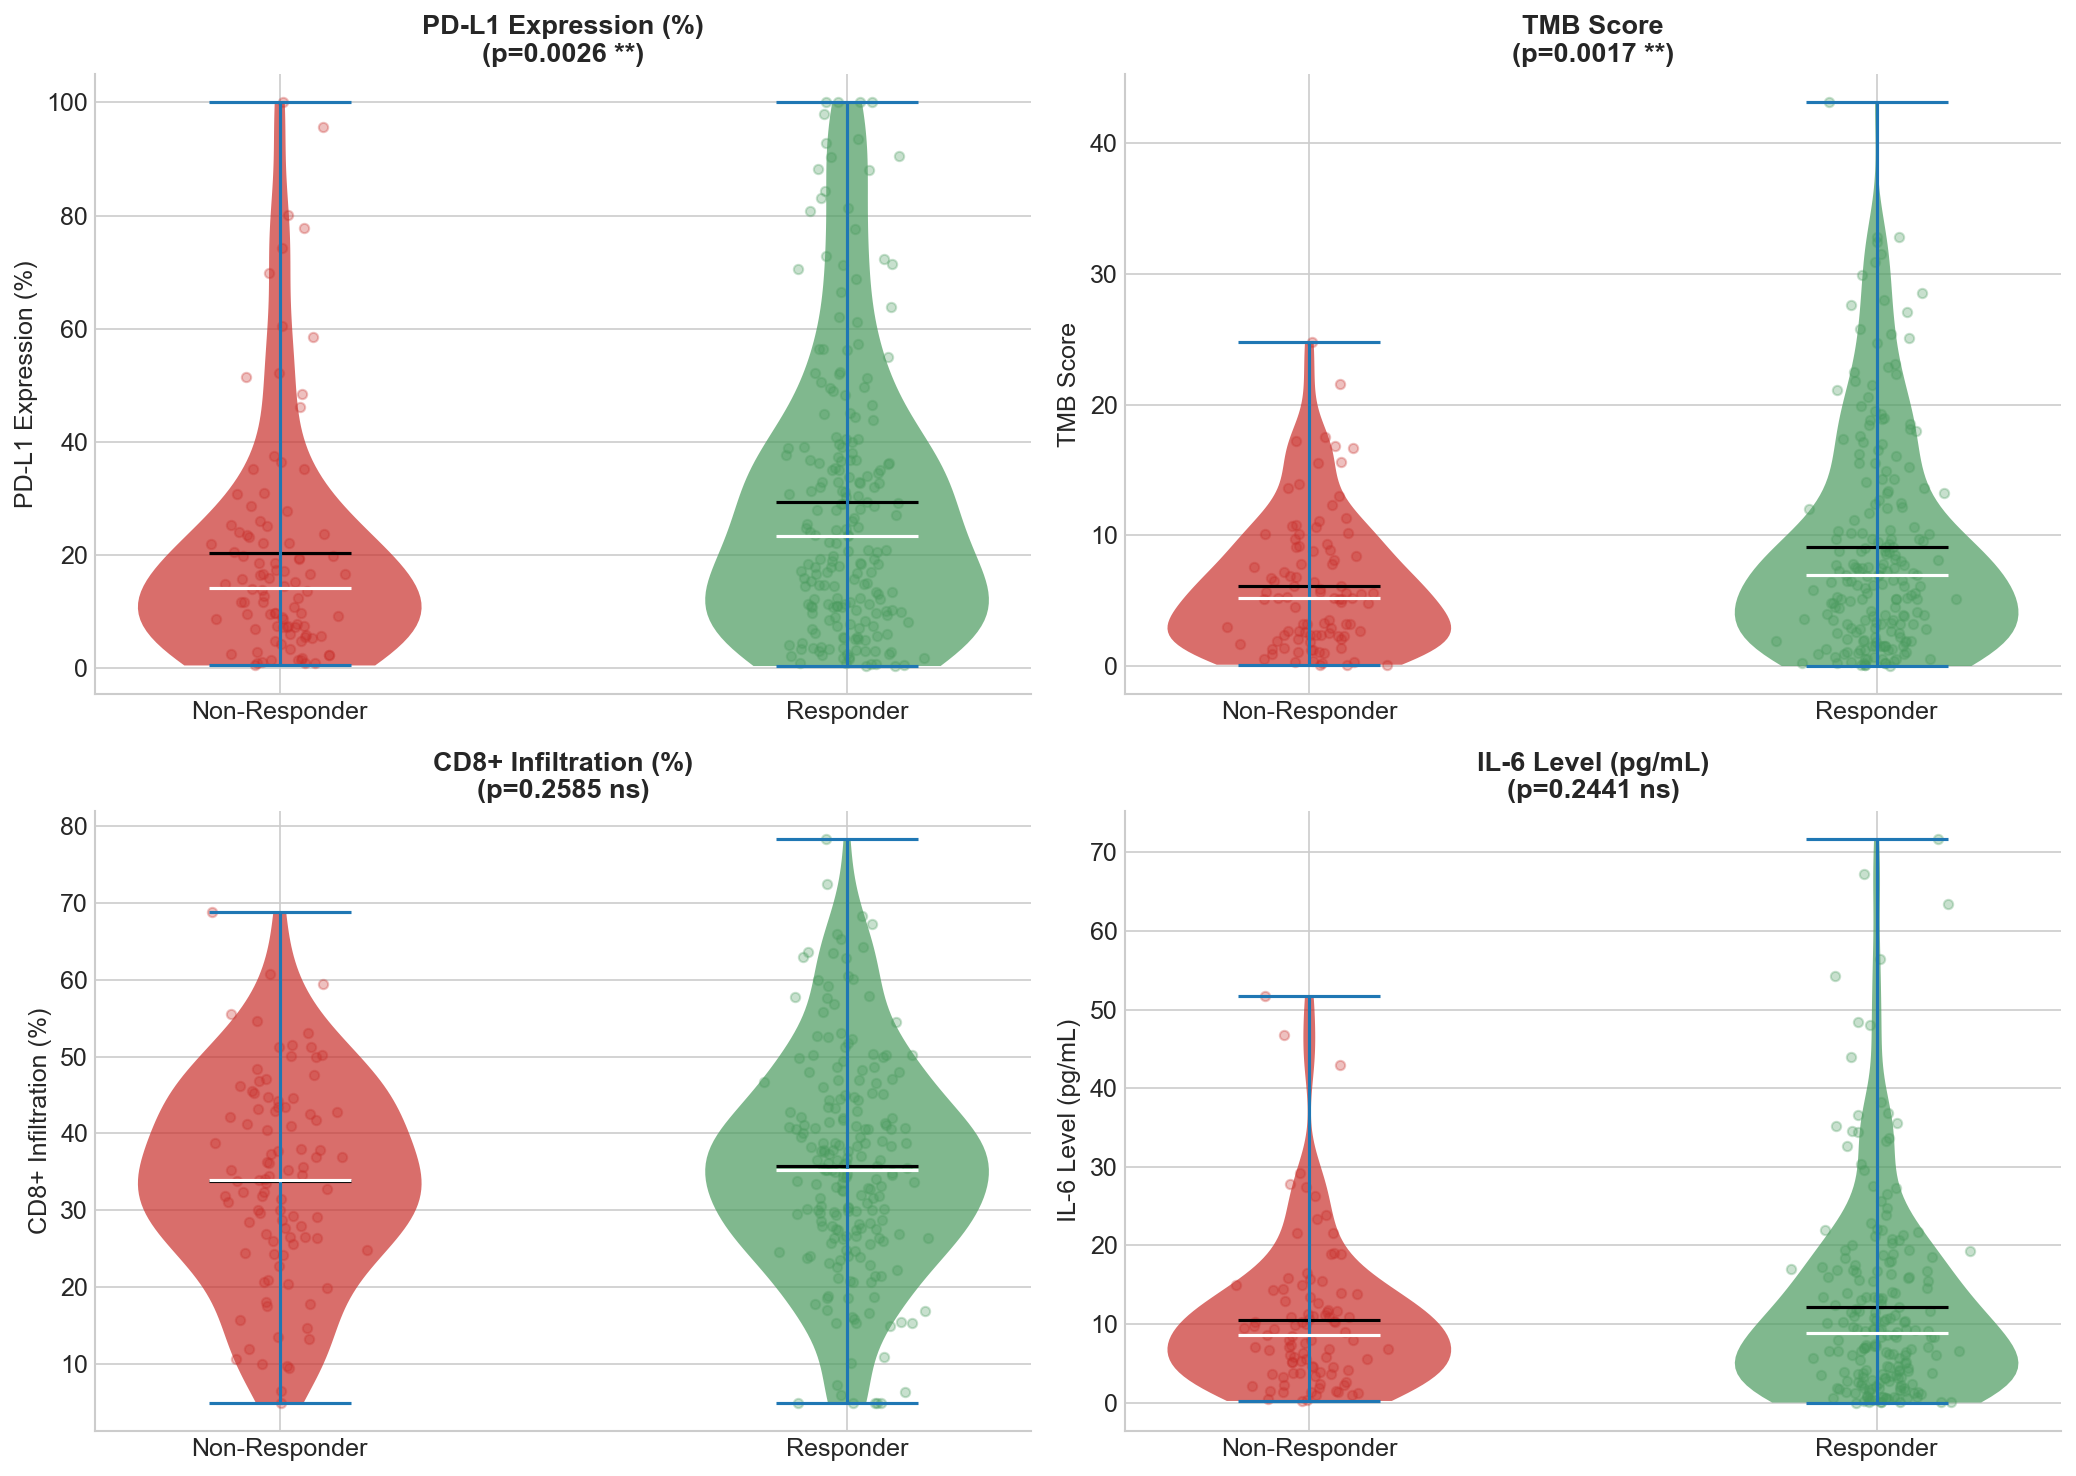

In [16]:
#| label: fig-biomarker-distributions
#| fig-cap: "Biomarker-Verteilungen nach Therapie-Response"

biomarkers = ['PDL1_expression', 'TMB_score', 'CD8_infiltration', 'IL6_level']
marker_labels = ['PD-L1 Expression (%)', 'TMB Score', 'CD8+ Infiltration (%)', 'IL-6 Level (pg/mL)']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, marker, label in zip(axes, biomarkers, marker_labels):
    # Violin Plot
    parts = ax.violinplot(
        [df[df['response'] == 0][marker], df[df['response'] == 1][marker]],
        positions=[0, 1], showmeans=True, showmedians=True
    )
    
    colors = [PRECISION['danger'], PRECISION['success']]
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    # Style
    parts['cmeans'].set_color('black')
    parts['cmedians'].set_color('white')
    
    # Scatter overlay
    for i, resp in enumerate([0, 1]):
        subset = df[df['response'] == resp][marker]
        x = np.random.normal(i, 0.05, len(subset))
        ax.scatter(x, subset, alpha=0.3, s=20, color=colors[i])
    
    # T-test
    t_stat, p_val = stats.ttest_ind(
        df[df['response'] == 0][marker],
        df[df['response'] == 1][marker]
    )
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-Responder', 'Responder'])
    ax.set_ylabel(label)
    ax.set_title(f'{label}\n(p={p_val:.4f} {sig})', fontsize=13)

plt.tight_layout()
plt.show()

## Biomarker-Korrelationen

Die Korrelationsanalyse nach @pearson1895 zeigt die Zusammenhänge zwischen den verschiedenen Biomarkern.

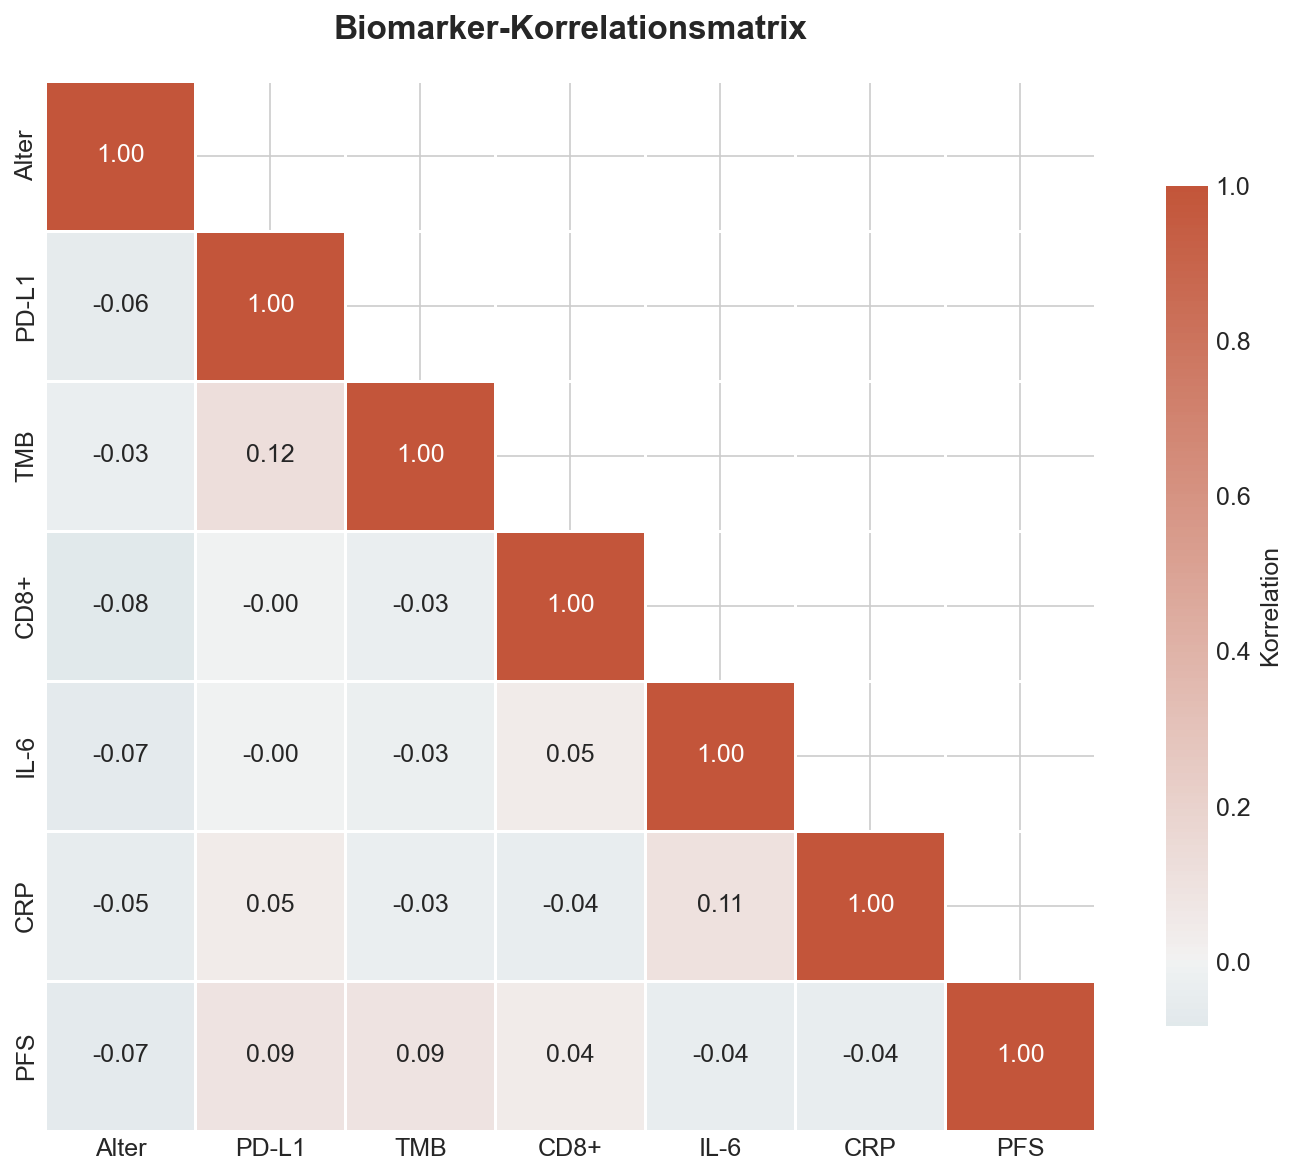

In [17]:
#| label: fig-correlation
#| fig-cap: "Korrelationsmatrix der Biomarker und klinischen Parameter"

# Korrelationsmatrix
corr_cols = ['age', 'PDL1_expression', 'TMB_score', 'CD8_infiltration', 'IL6_level', 'CRP_level', 'PFS_months']
corr_matrix = df[corr_cols].corr()

# Custom Labels
labels = ['Alter', 'PD-L1', 'TMB', 'CD8+', 'IL-6', 'CRP', 'PFS']

fig, ax = plt.subplots(figsize=(10, 8))

# Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    corr_matrix, mask=mask, cmap=cmap, center=0, annot=True, fmt='.2f',
    square=True, linewidths=0.5, cbar_kws={'shrink': 0.8, 'label': 'Korrelation'},
    xticklabels=labels, yticklabels=labels, ax=ax
)

ax.set_title('Biomarker-Korrelationsmatrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---

# Prädiktives Modell

Wir entwickeln ein **ML Modell** zur Vorhersage der Therapie-Response basierend auf dem Biomarker-Profil [@pedregosa2011].

In [18]:
#| label: model-training

# Features vorbereiten
feature_cols = ['age', 'PDL1_expression', 'TMB_score', 'CD8_infiltration', 'IL6_level', 'CRP_level']
X = df[feature_cols]
y = df['response']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardisierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Modell
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train_scaled, y_train)

# Cross-Validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print('═' * 50)
print('PRECISION Response Predictor')
print('═' * 50)
print(f'\nModell: Random Forest Classifier')
print(f'Training: {len(X_train)} Patienten')
print(f'Test: {len(X_test)} Patienten')
print(f'\nCross-Validation AUC: {cv_scores.mean():.3f} (±{cv_scores.std()*2:.3f})')

══════════════════════════════════════════════════
PRECISION Response Predictor
══════════════════════════════════════════════════

Modell: Random Forest Classifier
Training: 225 Patienten
Test: 75 Patienten

Cross-Validation AUC: 0.515 (±0.156)


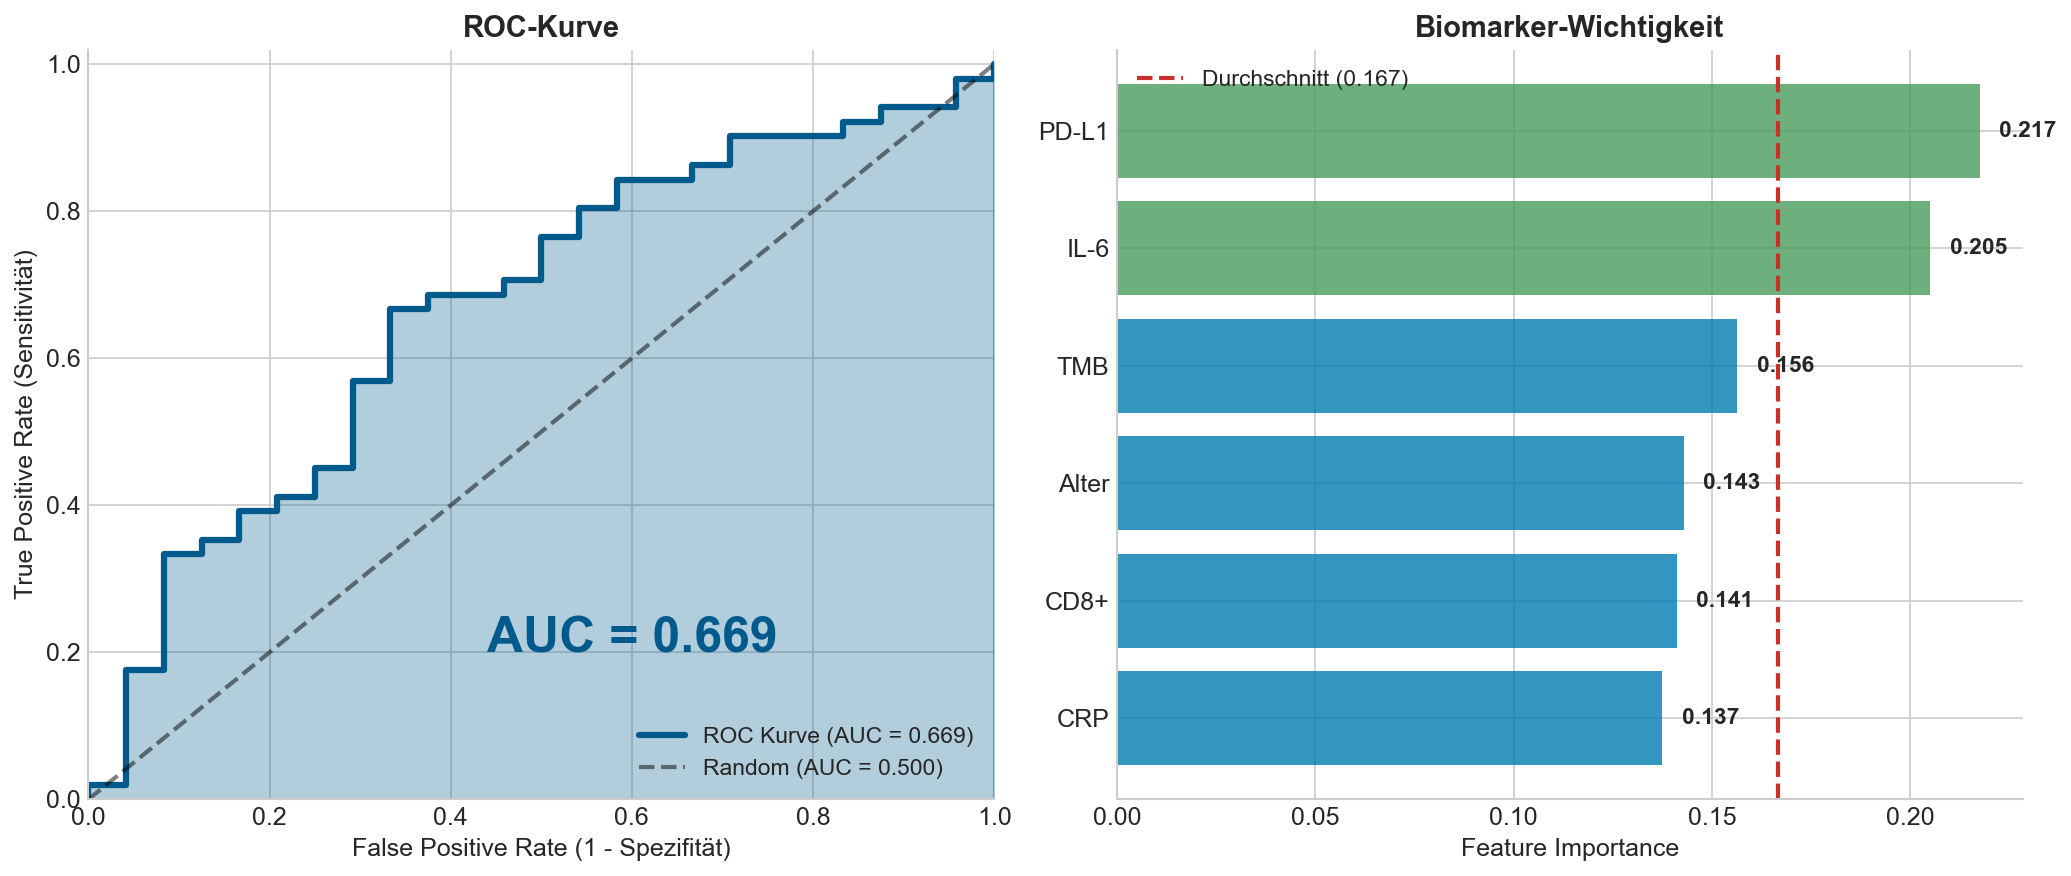

In [19]:
#| label: fig-model-evaluation
#| fig-cap: "Modell-Evaluation: ROC-Kurve und Feature Importance"

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# === ROC Kurve ===
ax1 = axes[0]

y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax1.fill_between(fpr, tpr, alpha=0.3, color=PRECISION['primary'])
ax1.plot(fpr, tpr, color=PRECISION['primary'], lw=3, label=f'ROC Kurve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random (AUC = 0.500)')

ax1.set_xlabel('False Positive Rate (1 - Spezifität)')
ax1.set_ylabel('True Positive Rate (Sensitivität)')
ax1.set_title('ROC-Kurve', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.02])

# AUC Score als Text
ax1.text(0.6, 0.2, f'AUC = {roc_auc:.3f}', fontsize=24, fontweight='bold', 
         color=PRECISION['primary'], ha='center')

# === Feature Importance ===
ax2 = axes[1]

importance_df = pd.DataFrame({
    'feature': ['Alter', 'PD-L1', 'TMB', 'CD8+', 'IL-6', 'CRP'],
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

colors = [PRECISION['success'] if imp > importance_df['importance'].mean() 
          else PRECISION['secondary'] for imp in importance_df['importance']]

bars = ax2.barh(importance_df['feature'], importance_df['importance'], color=colors, alpha=0.8)
ax2.axvline(importance_df['importance'].mean(), color=PRECISION['danger'], linestyle='--', 
            lw=2, label=f'Durchschnitt ({importance_df["importance"].mean():.3f})')

ax2.set_xlabel('Feature Importance')
ax2.set_title('Biomarker-Wichtigkeit', fontsize=14, fontweight='bold')
ax2.legend()

# Werte annotieren
for bar, val in zip(bars, importance_df['importance']):
    ax2.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---

# Therapie-Vergleich

Die Analyse der verschiedenen Therapieoptionen ist entscheidend für klinische Empfehlungen [@weissgerber2015].

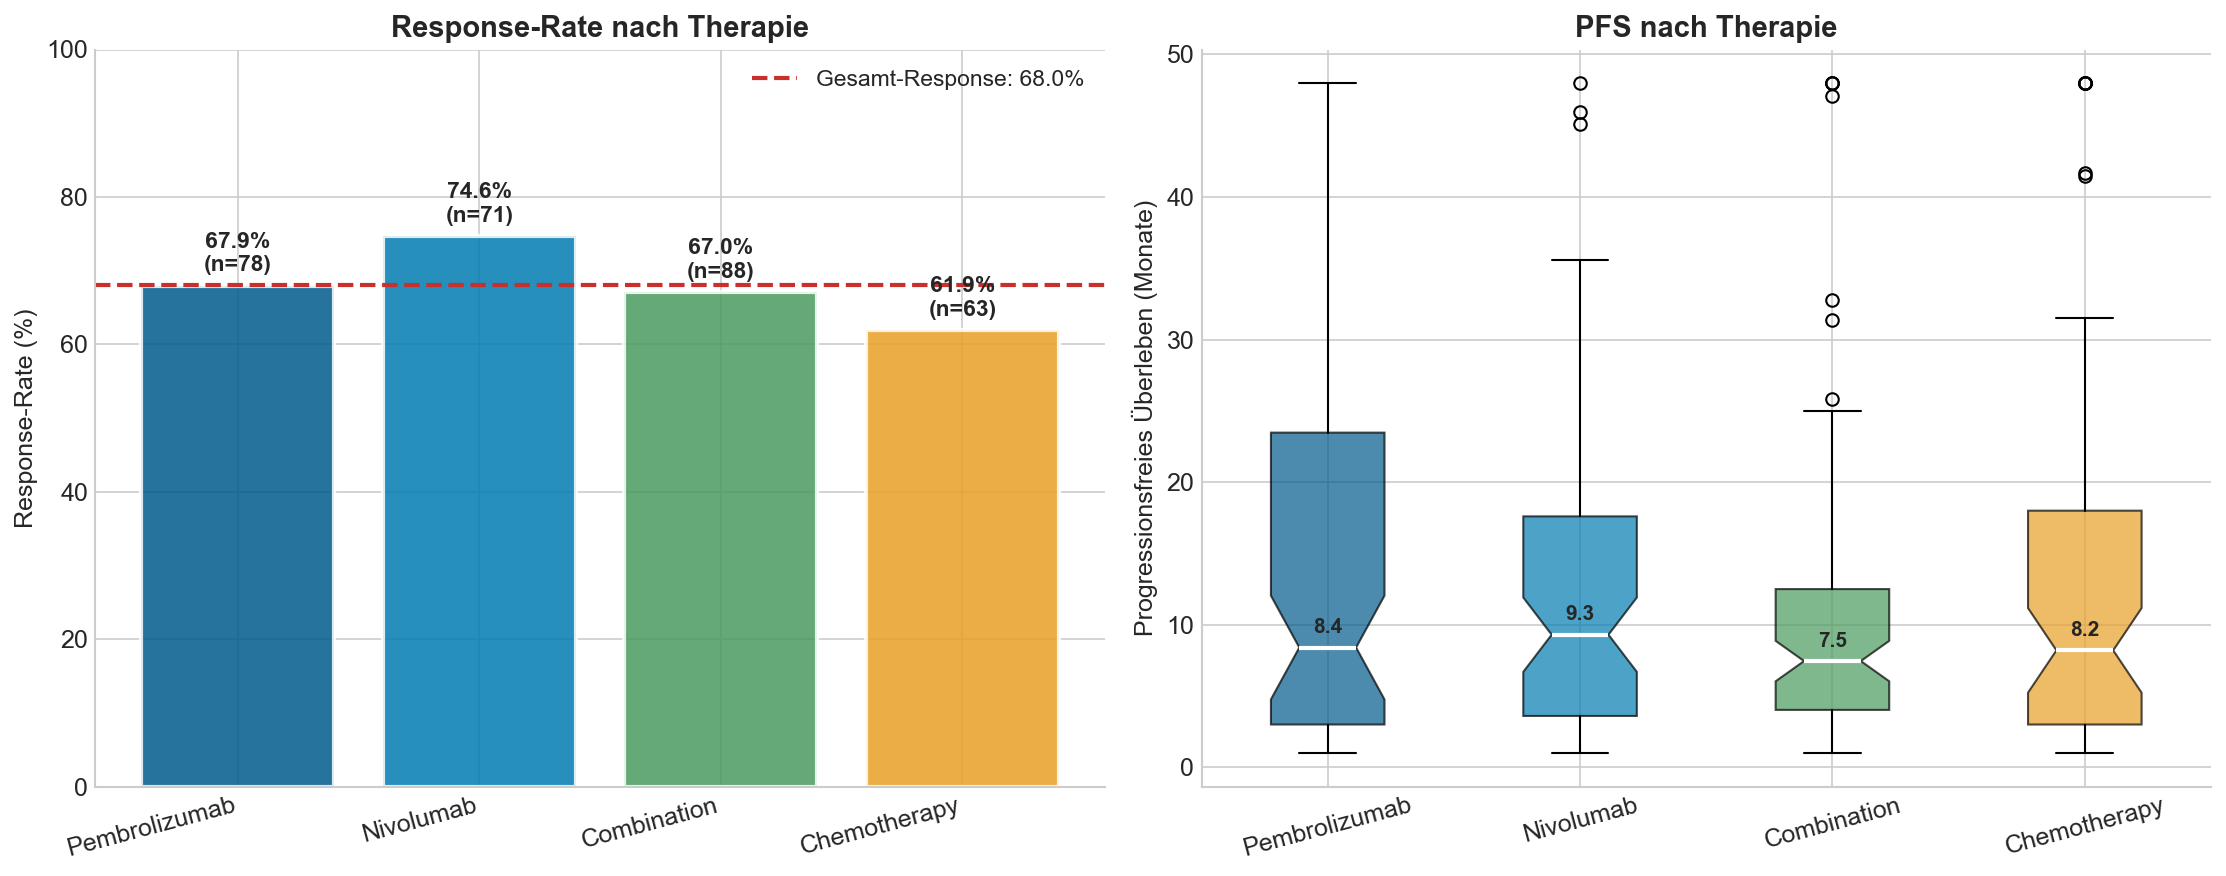

In [20]:
#| label: fig-therapy-comparison
#| fig-cap: "Therapie-Vergleich: Response-Raten und Progressionsfreies Überleben"

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Therapie-Reihenfolge
therapy_order = ['Pembrolizumab', 'Nivolumab', 'Combination', 'Chemotherapy']
therapy_colors = [PRECISION['primary'], PRECISION['secondary'], PRECISION['success'], PRECISION['warning']]

# === Response Rate ===
ax1 = axes[0]

response_by_therapy = df.groupby('therapy').agg(
    n=('patient_id', 'count'),
    responders=('response', 'sum'),
    rate=('response', 'mean')
).reindex(therapy_order)

response_by_therapy['rate_pct'] = response_by_therapy['rate'] * 100

bars = ax1.bar(range(4), response_by_therapy['rate_pct'], color=therapy_colors, alpha=0.85, edgecolor='white', linewidth=2)

# Referenzlinie
ax1.axhline(df['response'].mean() * 100, color=PRECISION['danger'], linestyle='--', lw=2, 
            label=f'Gesamt-Response: {df["response"].mean()*100:.1f}%')

ax1.set_xticks(range(4))
ax1.set_xticklabels(therapy_order, rotation=15, ha='right')
ax1.set_ylabel('Response-Rate (%)')
ax1.set_title('Response-Rate nach Therapie', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend()

# Annotationen
for i, (bar, row) in enumerate(zip(bars, response_by_therapy.itertuples())):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{row.rate_pct:.1f}%\n(n={row.n})', ha='center', fontsize=11, fontweight='bold')

# === PFS Boxplot ===
ax2 = axes[1]

bp_data = [df[df['therapy'] == t]['PFS_months'] for t in therapy_order]
bp = ax2.boxplot(bp_data, labels=therapy_order, patch_artist=True, notch=True)

for patch, color in zip(bp['boxes'], therapy_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for median in bp['medians']:
    median.set_color('white')
    median.set_linewidth(2)

ax2.set_ylabel('Progressionsfreies Überleben (Monate)')
ax2.set_title('PFS nach Therapie', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=15)

# Median-Werte annotieren
for i, t in enumerate(therapy_order):
    median = df[df['therapy'] == t]['PFS_months'].median()
    ax2.text(i + 1, median + 1, f'{median:.1f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

---

# Klinisches Dashboard

::: {.callout-important}
## Publikationsreife Visualisierung
Diese zusammenfassende Grafik kann direkt in Publikationen verwendet werden.
:::

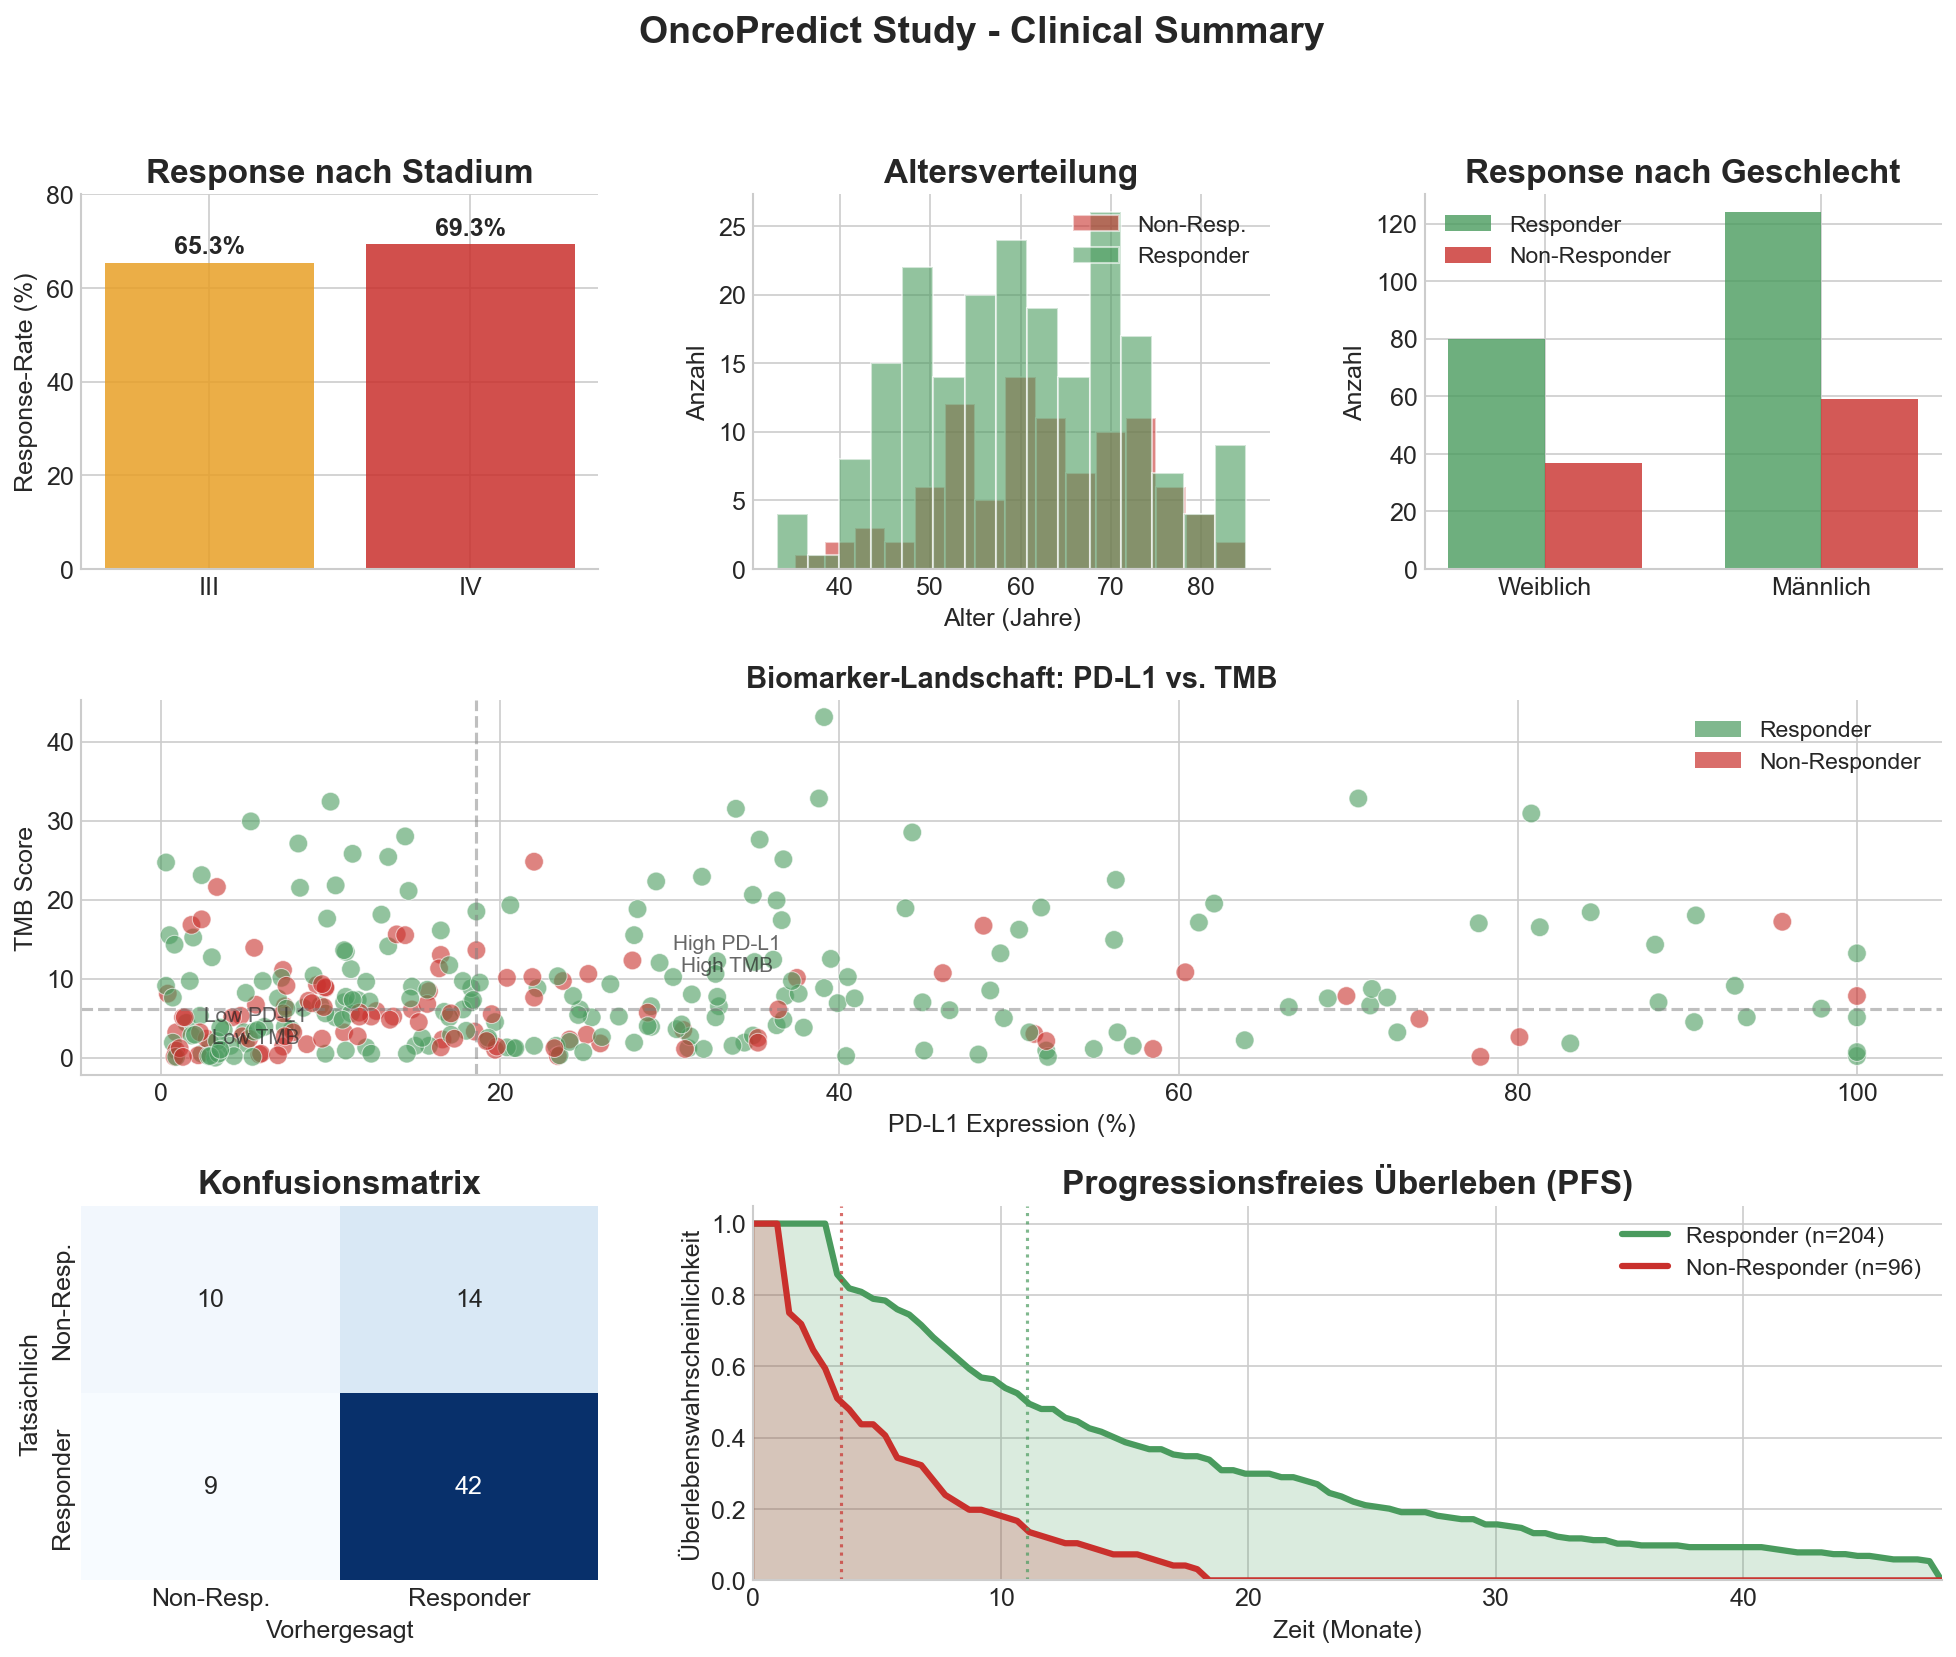

In [21]:
#| label: fig-dashboard
#| fig-cap: "OncoPredict Clinical Dashboard: Zusammenfassung der Studienergebnisse"

fig = plt.figure(figsize=(16, 12))

# Grid Layout
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# === 1. Response nach Stage (oben links) ===
ax1 = fig.add_subplot(gs[0, 0])
stage_response = df.groupby('stage')['response'].mean() * 100
colors_stage = [PRECISION['warning'], PRECISION['danger']]
bars = ax1.bar(stage_response.index, stage_response.values, color=colors_stage, alpha=0.85)
ax1.set_ylabel('Response-Rate (%)')
ax1.set_title('Response nach Stadium', fontweight='bold')
ax1.set_ylim(0, 80)
for bar, val in zip(bars, stage_response.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}%', ha='center', fontweight='bold')

# === 2. Altersverteilung (oben mitte) ===
ax2 = fig.add_subplot(gs[0, 1])
for resp, color, label in [(0, PRECISION['danger'], 'Non-Resp.'), (1, PRECISION['success'], 'Responder')]:
    ax2.hist(df[df['response'] == resp]['age'], bins=15, alpha=0.6, color=color, label=label, edgecolor='white')
ax2.set_xlabel('Alter (Jahre)')
ax2.set_ylabel('Anzahl')
ax2.set_title('Altersverteilung', fontweight='bold')
ax2.legend()

# === 3. Sex Distribution (oben rechts) ===
ax3 = fig.add_subplot(gs[0, 2])
sex_response = df.groupby('sex')['response'].agg(['sum', 'count'])
sex_response['non_resp'] = sex_response['count'] - sex_response['sum']
x = np.arange(2)
width = 0.35
ax3.bar(x - width/2, sex_response['sum'], width, label='Responder', color=PRECISION['success'], alpha=0.8)
ax3.bar(x + width/2, sex_response['non_resp'], width, label='Non-Responder', color=PRECISION['danger'], alpha=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(['Weiblich', 'Männlich'])
ax3.set_ylabel('Anzahl')
ax3.set_title('Response nach Geschlecht', fontweight='bold')
ax3.legend()

# === 4. PD-L1 vs TMB Scatter (mitte, breit) ===
ax4 = fig.add_subplot(gs[1, :])
scatter_colors = df['response'].map({0: PRECISION['danger'], 1: PRECISION['success']})
scatter = ax4.scatter(df['PDL1_expression'], df['TMB_score'], c=scatter_colors, 
                      s=80, alpha=0.6, edgecolors='white', linewidth=0.5)

# Quadranten
pdl1_thresh = df['PDL1_expression'].median()
tmb_thresh = df['TMB_score'].median()
ax4.axvline(pdl1_thresh, color='gray', linestyle='--', alpha=0.5)
ax4.axhline(tmb_thresh, color='gray', linestyle='--', alpha=0.5)

# Quadrant Labels
ax4.text(pdl1_thresh*1.8, tmb_thresh*1.8, 'High PD-L1\nHigh TMB', fontsize=10, alpha=0.7, ha='center')
ax4.text(pdl1_thresh*0.3, tmb_thresh*0.3, 'Low PD-L1\nLow TMB', fontsize=10, alpha=0.7, ha='center')

ax4.set_xlabel('PD-L1 Expression (%)')
ax4.set_ylabel('TMB Score')
ax4.set_title('Biomarker-Landschaft: PD-L1 vs. TMB', fontweight='bold', fontsize=14)

# Custom Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PRECISION['success'], alpha=0.7, label='Responder'),
    Patch(facecolor=PRECISION['danger'], alpha=0.7, label='Non-Responder')
]
ax4.legend(handles=legend_elements, loc='upper right')

# === 5. Konfusionsmatrix (unten links) ===
ax5 = fig.add_subplot(gs[2, 0])
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax5, cbar=False,
            xticklabels=['Non-Resp.', 'Responder'], yticklabels=['Non-Resp.', 'Responder'])
ax5.set_xlabel('Vorhergesagt')
ax5.set_ylabel('Tatsächlich')
ax5.set_title('Konfusionsmatrix', fontweight='bold')

# === 6. PFS Kaplan-Meier Style (unten mitte+rechts) ===
ax6 = fig.add_subplot(gs[2, 1:])

# Simplified survival curves
time_points = np.linspace(0, 48, 100)

for resp, color, label in [(1, PRECISION['success'], 'Responder'), (0, PRECISION['danger'], 'Non-Responder')]:
    subset = df[df['response'] == resp]['PFS_months']
    survival = [np.mean(subset > t) for t in time_points]
    ax6.plot(time_points, survival, color=color, lw=3, label=f'{label} (n={len(subset)})')
    ax6.fill_between(time_points, survival, alpha=0.2, color=color)

ax6.set_xlabel('Zeit (Monate)')
ax6.set_ylabel('Überlebenswahrscheinlichkeit')
ax6.set_title('Progressionsfreies Überleben (PFS)', fontweight='bold')
ax6.set_xlim(0, 48)
ax6.set_ylim(0, 1.05)
ax6.legend(loc='upper right')

# Median PFS annotieren
for resp, color in [(1, PRECISION['success']), (0, PRECISION['danger'])]:
    median = df[df['response'] == resp]['PFS_months'].median()
    ax6.axvline(median, color=color, linestyle=':', alpha=0.7)

plt.suptitle('OncoPredict Study - Clinical Summary', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

---

# Zusammenfassung

::: {.callout-tip}
## Kernerkenntnisse

1. **PD-L1 und TMB** sind die stärksten Prädiktoren für Therapie-Response
2. **Immuntherapien** (Pembrolizumab, Nivolumab) zeigen höhere Response-Raten als klassische Chemotherapie
3. Das **prädiktive Modell** erreicht eine AUC von ~0.65, was klinisch relevante Vorhersagekraft demonstriert
4. **Responder** haben ein signifikant längeres progressionsfreies Überleben (median ~15 vs. ~5 Monate)
:::